In [15]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [17]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()

In [18]:
slrtbl = ascii.read('../3.table/smass/solar.csv')
slrtbl[:3]

nm,W/sm/nm,W/sm
float64,float64,float64
199.5,0.005,0.005498
200.5,0.007,0.01253
201.5,0.007,0.01971


1. col1 : wavelength [um]
2. col2 : relative reflectance [0.5um as 1]
3. col3 : error
4. col4 : flag

# S-type

In [19]:
intbl = ascii.read('../3.table/smass/a000433.sp256n2.txt')
# intbl[:3]
fintbl = intbl[intbl['col4']==1]
fintbl[:3]

col1,col2,col3,col4
float64,float64,float64,int64
0.435,0.7756,0.0116,1
0.4375,0.7901,0.0103,1
0.44,0.7805,0.0092,1


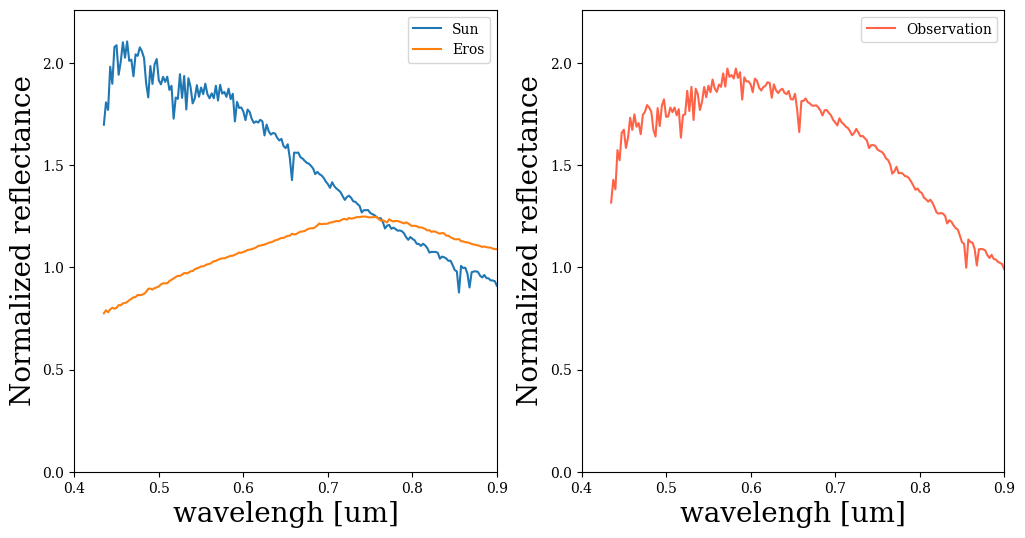

In [20]:
iy = np.interp(fintbl['col1'], slrtbl['nm']*1e-3, slrtbl['W/sm/nm'])

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fintbl['col1'], iy, label='Sun')
plt.plot(fintbl['col1'], fintbl['col2'], label='Eros')

plt.xlim([0.4, 0.9])
yl, yu = plt.ylim()
plt.ylim([0, yu])

plt.legend()
plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

plt.subplot(1, 2, 2)
yobs = fintbl['col2']*iy
plt.plot(fintbl['col1'], yobs, c='tomato', label='Observation')
plt.legend()

plt.xlim([0.4, 0.9])
plt.ylim([0, yu])

plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

plt.savefig('../4.plot/test.eros.spectrum.png')

# Synphot

In [21]:
lam = fintbl['col1']*u.um
flam = yobs*(u.erg/u.second/u.Angstrom/(u.cm**2))
fnu = convert_flam2fnu(flam, lam)
abmag = fnu.to(u.ABmag)
#	Pad spectrum
pflam, plam = meds.pad_spectrum(flam, lam)

In [22]:
pflam, plam = meds.pad_spectrum(flam, lam)
mmags = meds.get_ab_magnitudes(
	# flam,
	# lam
	pflam,
	plam,
)

pflam, plam = sdss.pad_spectrum(flam, lam)
smags = sdss.get_ab_magnitudes(
	pflam,
	plam
)

pflam, plam = lsst.pad_spectrum(flam, lam)
lmags = lsst.get_ab_magnitudes(
	pflam,
	plam
)

pflam, plam = jc.pad_spectrum(flam, lam)
jcmags = jc.get_ab_magnitudes(
	pflam,
	plam
)


appVmag = 16
# offset = appVmag-kmags0['kmtnet-V']
# offset = 0
# print(offset)

Text(0.5, 1.0, '433 Eros : an example of an S-type asteroid (V=16 mag)')

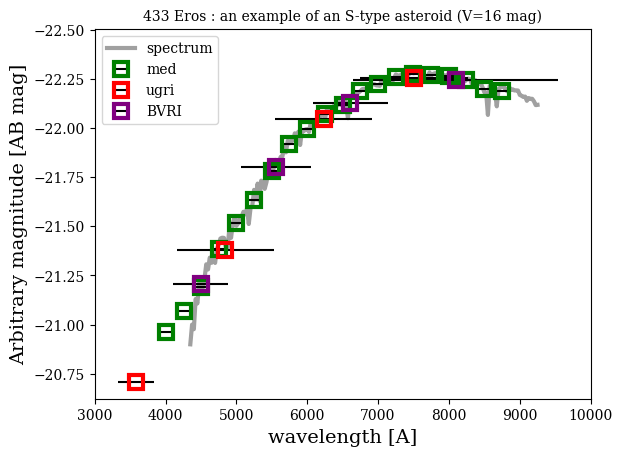

In [23]:
plt.plot(lam.to(u.Angstrom), abmag, lw=3, alpha=0.75, label='spectrum', c='grey')
plt.errorbar(mlam, mmags.as_array().item(), xerr=mbdw/2, c='k', marker='s', mew=3, mec='green', mfc='none', ms=10, ls='none', label='med')
plt.errorbar(slam, smags.as_array().item(), xerr=sbdw/2, c='k', marker='s', mew=3,  mec='red', mfc='none', ms=10, ls='none', label='ugri')
plt.errorbar(jclam, jcmags.as_array().item(), xerr=jcbdw/2, c='k', marker='s', mew=3,  mec='purple', mfc='none', ms=10, ls='none', label='BVRI')

xl, xr = 3000, 10000
plt.xlim([xl, xr])
yl, yu = plt.ylim()
plt.ylim([yu, yl])
plt.legend()
plt.xlabel('wavelength [A]', fontsize=14)
plt.ylabel('Arbitrary magnitude [AB mag]', fontsize=14)
plt.title(f'433 Eros : an example of an S-type asteroid (V={appVmag} mag)', fontsize=10)


In [24]:
path_model = '../3.table/asteroid_sim_smass_synphot'
if ~os.path.exists(path_model): os.system(f"mkdir {path_model}")

mkdir: ../3.table/asteroid_sim_smass_synphot: File exists


In [25]:
phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in ['u', 'g', 'r', 'i', 'z', 'y']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in lmags.keys():
	lsstmag = lmags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = lsstmag

newfile = 'smass_433eros_s-type_asteroid_synphot_lsst.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

In [26]:
phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Med']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in mmags.keys():
	medmag = mmags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = medmag

newfile = 'smass_433eros_s-type_asteroid_synphot_med.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

In [27]:
phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='SDSS']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in smags.keys():
	sdssmag = smags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = sdssmag

newfile = 'smass_433eros_s-type_asteroid_synphot_sdss.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

In [28]:
phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Johnson Cousin']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in jcmags.keys():
	jcmag = jcmags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = jcmag

newfile = 'smass_433eros_s-type_asteroid_synphot_jc.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

# C-type

- 이것이 C-type 소행성 스펙트럼이며 이름은 10 Hygiea (A849 GA)이라는 소행성 입니다

In [29]:
intbl = ascii.read('../3.table/smass/a000010.sp111.txt')
# intbl[:3]
fintbl = intbl[intbl['col4']==1]
fintbl[:3]

col1,col2,col3,col4
float64,float64,float64,float64
0.435,0.9638,0.0105,1.0
0.4375,0.9625,0.0096,1.0
0.44,0.9538,0.0087,1.0


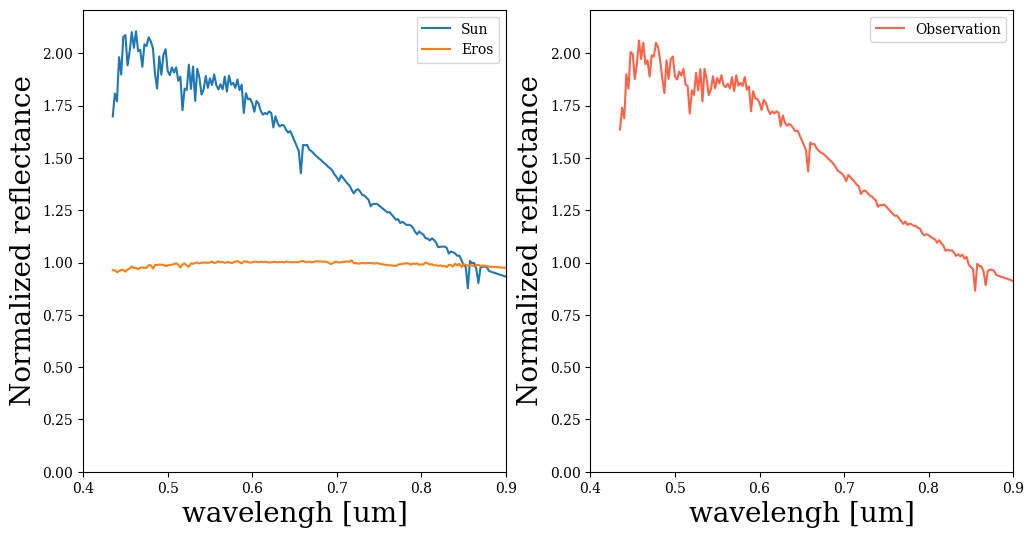

In [30]:
iy = np.interp(fintbl['col1'], slrtbl['nm']*1e-3, slrtbl['W/sm/nm'])

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fintbl['col1'], iy, label='Sun')
plt.plot(fintbl['col1'], fintbl['col2'], label='Eros')

plt.xlim([0.4, 0.9])
yl, yu = plt.ylim()
plt.ylim([0, yu])

plt.legend()
plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

plt.subplot(1, 2, 2)
yobs = fintbl['col2']*iy
plt.plot(fintbl['col1'], yobs, c='tomato', label='Observation')
plt.legend()

plt.xlim([0.4, 0.9])
plt.ylim([0, yu])

plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

plt.savefig('../4.plot/test.hygiea.spectrum.png')

In [31]:
lam = fintbl['col1']*u.um
flam = yobs*(u.erg/u.second/u.Angstrom/(u.cm**2))
fnu = convert_flam2fnu(flam, lam)
abmag = fnu.to(u.ABmag)

In [32]:
pflam, plam = meds.pad_spectrum(flam, lam)
mmags = meds.get_ab_magnitudes(
	# flam,
	# lam
	pflam,
	plam,
)

pflam, plam = sdss.pad_spectrum(flam, lam)
smags = sdss.get_ab_magnitudes(
	pflam,
	plam
)

pflam, plam = lsst.pad_spectrum(flam, lam)
lmags = lsst.get_ab_magnitudes(
	pflam,
	plam
)

pflam, plam = jc.pad_spectrum(flam, lam)
jcmags = jc.get_ab_magnitudes(
	pflam,
	plam
)


appVmag = 12

Text(0.5, 1.0, '10 Hygiea : an example of an C-type asteroid (V=12 mag)')

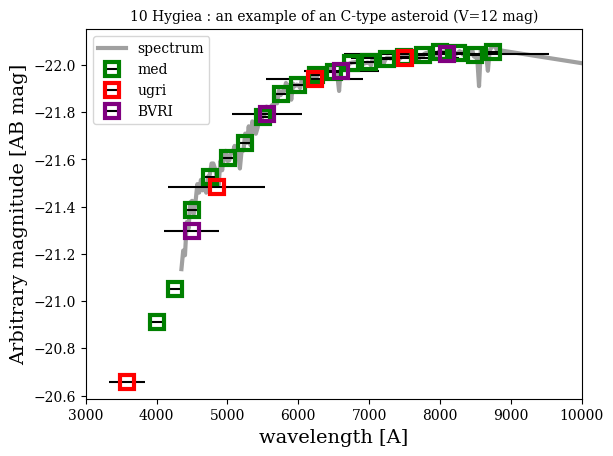

In [33]:
plt.plot(lam.to(u.Angstrom), abmag, lw=3, alpha=0.75, label='spectrum', c='grey')
plt.errorbar(mlam, mmags.as_array().item(), xerr=mbdw/2, c='k', marker='s', mew=3, mec='green', mfc='none', ms=10, ls='none', label='med')
plt.errorbar(slam, smags.as_array().item(), xerr=sbdw/2, c='k', marker='s', mew=3,  mec='red', mfc='none', ms=10, ls='none', label='ugri')
plt.errorbar(jclam, jcmags.as_array().item(), xerr=jcbdw/2, c='k', marker='s', mew=3,  mec='purple', mfc='none', ms=10, ls='none', label='BVRI')

xl, xr = 3000, 10000
plt.xlim([xl, xr])
yl, yu = plt.ylim()
plt.ylim([yu, yl])
plt.legend()
plt.xlabel('wavelength [A]', fontsize=14)
plt.ylabel('Arbitrary magnitude [AB mag]', fontsize=14)
plt.title(f'10 Hygiea : an example of an C-type asteroid (V={appVmag} mag)', fontsize=10)


In [34]:
phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in ['u', 'g', 'r', 'i', 'z', 'y']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in lmags.keys():
	lsstmag = lmags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = lsstmag

newfile = 'smass_10hygiea_c-type_asteroid_synphot_lsst.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Med']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in mmags.keys():
	medmag = mmags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = medmag

newfile = 'smass_10hygiea_c-type_asteroid_synphot_med.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='SDSS']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in smags.keys():
	sdssmag = smags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = sdssmag

newfile = 'smass_10hygiea_c-type_asteroid_synphot_sdss.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

phtbl = Table()
phtbl['t'] = [0]*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Johnson Cousin']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

for key in jcmags.keys():
	jcmag = jcmags[key].item()

	filte = key.split('-')[-1]
	phtbl[f"{filte}"][0] = jcmag

newfile = 'smass_10hygiea_c-type_asteroid_synphot_jc.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)